In [1]:
import os
print("SPARK_HOME:", os.environ.get("SPARK_HOME"))
print("HADOOP_HOME:", os.environ.get("HADOOP_HOME"))

SPARK_HOME: C:\spark\spark-3.4.1-bin-hadoop3\spark-3.4.1-bin-hadoop3
HADOOP_HOME: C:\hadoop


In [2]:
import findspark
findspark.init()

In [3]:
# Loading pyspark libraries for KMeans
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [4]:
# Loading other required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext('local[*]')
spark = SparkSession(sc)

In [6]:
# Loading dataset
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [9]:
df1 = spark.createDataFrame(df)

In [10]:
df1.printSchema()

root
 |-- CustomerID: long (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Annual Income (k$): long (nullable = true)
 |-- Spending Score (1-100): long (nullable = true)



In [11]:
#!pip show pyspark

In [8]:
# Encoding Gender
def change_gender(item):
    if item == "Male":
        return 0
    else:
        return 1

df["Gender"] = df["Genre"].apply(change_gender,1)
df = df[["Gender","Age","Annual Income (k$)","Spending Score (1-100)"]]

In [11]:
# Converting pandas dataframe into spark dataframe
from pyspark.sql.types import StructType, StructField, NumericType
spark_df = spark.createDataFrame(df)

In [12]:
from pyspark.ml.feature import VectorAssembler
features = tuple(df.columns)
features

('Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)')

In [13]:
# Making a spark dataframe
assembler = VectorAssembler(inputCols=features,outputCol="features")
dataset = assembler.transform(spark_df)
dataset.select("features").show(truncate=False)

+--------------------+
|features            |
+--------------------+
|[0.0,19.0,15.0,39.0]|
|[0.0,21.0,15.0,81.0]|
|[1.0,20.0,16.0,6.0] |
|[1.0,23.0,16.0,77.0]|
|[1.0,31.0,17.0,40.0]|
|[1.0,22.0,17.0,76.0]|
|[1.0,35.0,18.0,6.0] |
|[1.0,23.0,18.0,94.0]|
|[0.0,64.0,19.0,3.0] |
|[1.0,30.0,19.0,72.0]|
|[0.0,67.0,19.0,14.0]|
|[1.0,35.0,19.0,99.0]|
|[1.0,58.0,20.0,15.0]|
|[1.0,24.0,20.0,77.0]|
|[0.0,37.0,20.0,13.0]|
|[0.0,22.0,20.0,79.0]|
|[1.0,35.0,21.0,35.0]|
|[0.0,20.0,21.0,66.0]|
|[0.0,52.0,23.0,29.0]|
|[1.0,35.0,23.0,98.0]|
+--------------------+
only showing top 20 rows



In [23]:
# Creating KMeans 
kmeans = KMeans().setK(5).setSeed(42)
model = kmeans.fit(dataset)

predictions = model.transform(dataset)
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouetter with squared euclidean distance = {}".format(silhouette))

print("Cluster Centers: ")
ctr = []
centers = model.clusterCenters()

for center in centers:
    ctr.append(center)
    print(center)

Silhouetter with squared euclidean distance = 0.6276007113904093
Cluster Centers: 
[ 0.48648649 40.32432432 87.43243243 18.18918919]
[ 0.56 24.96 28.04 77.  ]
[ 0.59210526 43.93421053 55.21052632 49.44736842]
[ 0.53846154 32.69230769 86.53846154 82.12820513]
[ 0.60869565 45.2173913  26.30434783 20.91304348]


In [24]:
centers = pd.DataFrame(ctr,columns=features)
centers.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0.486486,40.324324,87.432432,18.189189
1,0.560000,24.960000,28.040000,77.000000
2,0.592105,43.934211,55.210526,49.447368
3,0.538462,32.692308,86.538462,82.128205
4,0.608696,45.217391,26.304348,20.913043


In [25]:
predictions_df = predictions.toPandas()
predictions_df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),features,prediction
0,0,19,15,39,"[0.0, 19.0, 15.0, 39.0]",4
1,0,21,15,81,"[0.0, 21.0, 15.0, 81.0]",1
2,1,20,16,6,"[1.0, 20.0, 16.0, 6.0]",4
3,1,23,16,77,"[1.0, 23.0, 16.0, 77.0]",1
4,1,31,17,40,"[1.0, 31.0, 17.0, 40.0]",4


In [26]:
predictions_df[predictions_df["prediction"] == 0]["Annual Income (k$)"].values

array([ 70,  71,  71,  72,  73,  73,  74,  75,  76,  77,  77,  78,  78,
        78,  78,  78,  78,  79,  81,  85,  86,  87,  87,  87,  88,  88,
        93,  97,  98,  99, 101, 103, 103, 113, 120, 126, 137], dtype=int64)

In [27]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')


In [28]:
zero_income = predictions_df[predictions_df["prediction"] == 0]["Annual Income (k$)"].values
zero_spendingScore = predictions_df[predictions_df["prediction"] == 0]["Spending Score (1-100)"].values

one_income = predictions_df[predictions_df["prediction"] == 1]["Annual Income (k$)"].values
one_spendingScore = predictions_df[predictions_df["prediction"] == 1]["Spending Score (1-100)"].values

two_income = predictions_df[predictions_df["prediction"] == 2]["Annual Income (k$)"].values
two_spendingScore = predictions_df[predictions_df["prediction"] == 2]["Spending Score (1-100)"].values

three_income = predictions_df[predictions_df["prediction"] == 3]["Annual Income (k$)"].values
three_spendingScore = predictions_df[predictions_df["prediction"] == 3]["Spending Score (1-100)"].values

four_income = predictions_df[predictions_df["prediction"] == 4]["Annual Income (k$)"].values
four_spendingScore = predictions_df[predictions_df["prediction"] == 4]["Spending Score (1-100)"].values

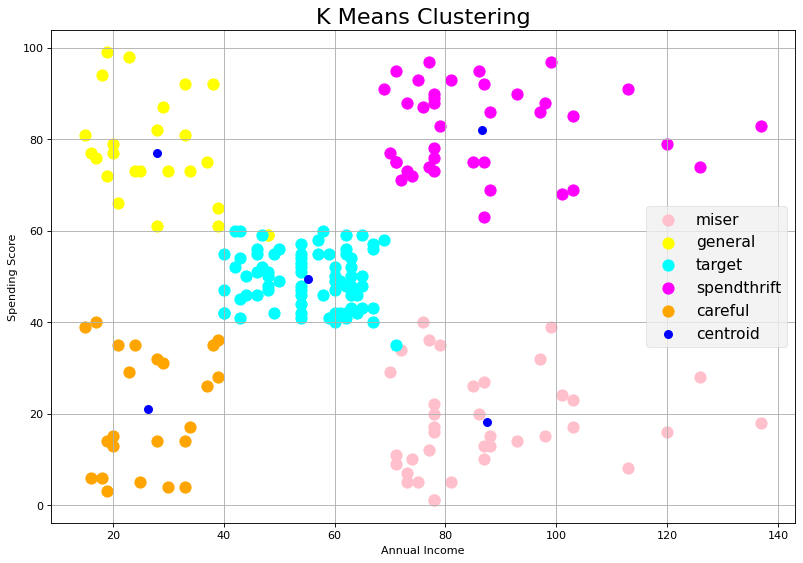

In [29]:
from matplotlib.pyplot import figure

fig = figure(figsize=(12,8), dpi=80)
plt.scatter(zero_income,zero_spendingScore,s=100,c='pink',label='miser')
plt.scatter(one_income,one_spendingScore,s=100,c='yellow',label='general')
plt.scatter(two_income,two_spendingScore,s=100,c='cyan',label='target')
plt.scatter(three_income,three_spendingScore,s=100,c='magenta',label='spendthrift')
plt.scatter(four_income,four_spendingScore,s=100,c='orange',label='careful')
plt.scatter(centers["Annual Income (k$)"],centers["Spending Score (1-100)"],s=50,c='blue',label='centroid')

plt.style.use('fivethirtyeight')
plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show()